Source: https://drive.google.com/file/d/1VSAbzyOZ4wueVdkj-2yrUw13tNtAV8bt/view


# Setup


In [13]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

import matplotlib as mpl

import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA

Let's build a simple 3D dataset:


In [40]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [41]:
X

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496],
       [ 1.11816122,  0.32508721,  0.31710572],
       [-1.02258878, -0.64384064, -0.13368695],
       [ 0.67351984, -0.27342519, -0.00787835],
       [ 1.01619558,  0.51546608,  0.46783297],
       [ 0.54957723,  0.67728016,  0.2340159 ],
       [-0.98960443,  0.00886617, -0.12152034],
       [ 1.13248106,  0.28229967,  0.06972972],
       [-0.99337712, -0.26832824, -0.15761101],
       [-0.94763679, -0.4995849 , -0.13927911],
       [ 1.10095709,  0.1706481 ,  0.09790432],
       [-0.34604591,  0.45334414,  0.06433843],
       [ 0.69102621, -0.27337761, -0.05926516],
       [ 0.68302902,  0.70421846,  0.24642318],
       [ 0.8774031 , -0.16775101, -0.02162333],
       [-1.06090127, -0.48213721, -0.38573526],
       [ 0.52336644,  0.66585845,  0.390

# Using Scikit-Learn


With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:


In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [43]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Recover the 3D points projected on the plane (PCA 2D subspace).


In [18]:
X3D_inv = pca.inverse_transform(X2D)

There was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:


In [44]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error (Mean Square Error):


In [45]:
error = np.mean(np.sum(np.square(X3D_inv - X), axis=1))
print("MSE:", error)

MSE: 0.010170337792848549


The `PCA` object gives access to the principal components that it computed.
In this case, 2 principle components are as follow:


In [46]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

# Explain Variance Ratio


In [47]:
print(
    "The explained ratio of 2 principle components are:", pca.explained_variance_ratio_
)

The explained ratio of 2 principle components are: [0.84248607 0.14631839]


The first dimension explains 84.2% of the variance, while the second explains 14.6%.\
By projecting down to 2D, we lost about 1.1% of the variance:


In [23]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

# Visualization


Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)


In [48]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.


In [49]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.


C:\Users\phi.nguyen\AppData\Local\Temp\ipykernel_18616\2863899813.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


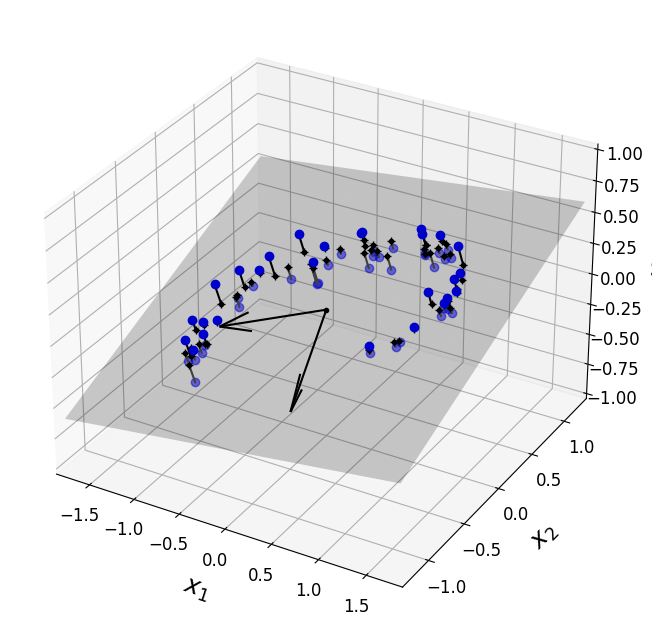

In [50]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(25, 8))
ax = fig.add_subplot(111, projection="3d")

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

# Replaced Arrow3D with arrow function
ax.quiver(
    [0, 0],
    [0, 0],
    [0, 0],
    [C[0, 0], C[1, 0]],
    [C[0, 1], C[1, 1]],
    [C[0, 2], C[1, 2]],
    color="k",
)

ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot(
            [X[i][0], X3D_inv[i][0]],
            [X[i][1], X3D_inv[i][1]],
            [X[i][2], X3D_inv[i][2]],
            "k-",
        )
    else:
        ax.plot(
            [X[i][0], X3D_inv[i][0]],
            [X[i][1], X3D_inv[i][1]],
            [X[i][2], X3D_inv[i][2]],
            "k-",
            color="#505050",
        )

ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

New 2D dataset after projection


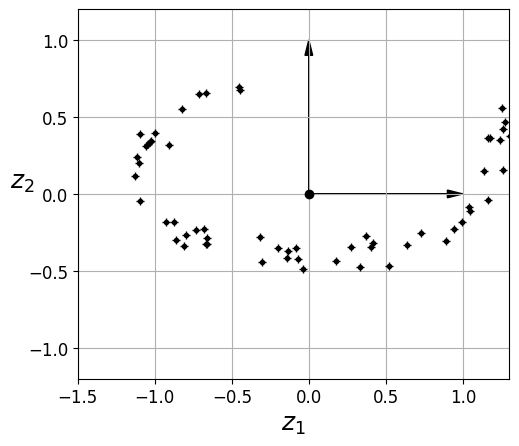

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(
    0,
    0,
    0,
    1,
    head_width=0.05,
    length_includes_head=True,
    head_length=0.1,
    fc="k",
    ec="k",
)
ax.arrow(
    0,
    0,
    1,
    0,
    head_width=0.05,
    length_includes_head=True,
    head_length=0.1,
    fc="k",
    ec="k",
)
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

## Choosing the Right Number of Dimensions


In [51]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [52]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)  # 75%

Choose the features that keep 95% variance of the original data


In [30]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("The number of dimensions keeping 95% variance is:", d)

The number of dimensions keeping 95% variance is: 154


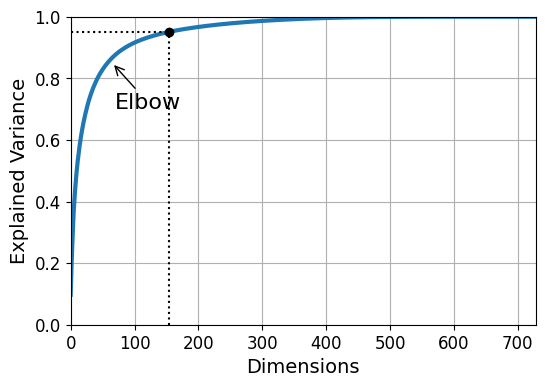

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 728, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate(
    "Elbow",
    xy=(65, 0.85),
    xytext=(70, 0.7),
    arrowprops=dict(arrowstyle="->"),
    fontsize=16,
)
plt.grid(True)
# save_fig("explained_variance_plot")
plt.show()

We can let the libraries find the number of components keeping 95% of information (variance)


In [53]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca.n_components_

154

## PCA for compression

In [33]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

**Code to generate Figure 8–9. MNIST compression that preserves 95% of the variance:**

Text(0.5, 1.0, 'Compressed')

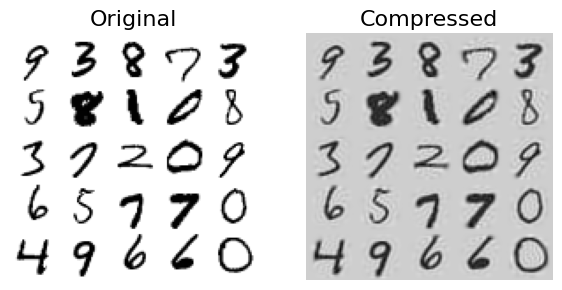

In [34]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")


plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

# save_fig("mnist_compression_plot")

# PCA variants

- **Randomized PCA** \
Use Case: Faster computation for large datasets. \
Description: Uses approximated Singular Value Decomposition (SVD) for faster computation when the number of principal components is much smaller than the number of data points

In [35]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

- **Incremental PCA** \
Use Case: Large datasets that cannot fit into memory all at once. \
Description: Processes data in mini-batches, making it suitable for big data problems.

In [36]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

- **Kernel PCA** \
Use Case: Handling non-linear data distributions.\
Description: Uses a kernel trick to transform data into a higher-dimensional space where it becomes more linearly separable

In [37]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True
)
sig_pca = KernelPCA(
    n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True
)

swiss roll data

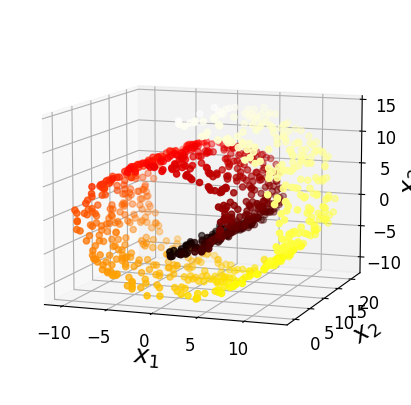

In [38]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("swiss_roll_plot")
plt.show()

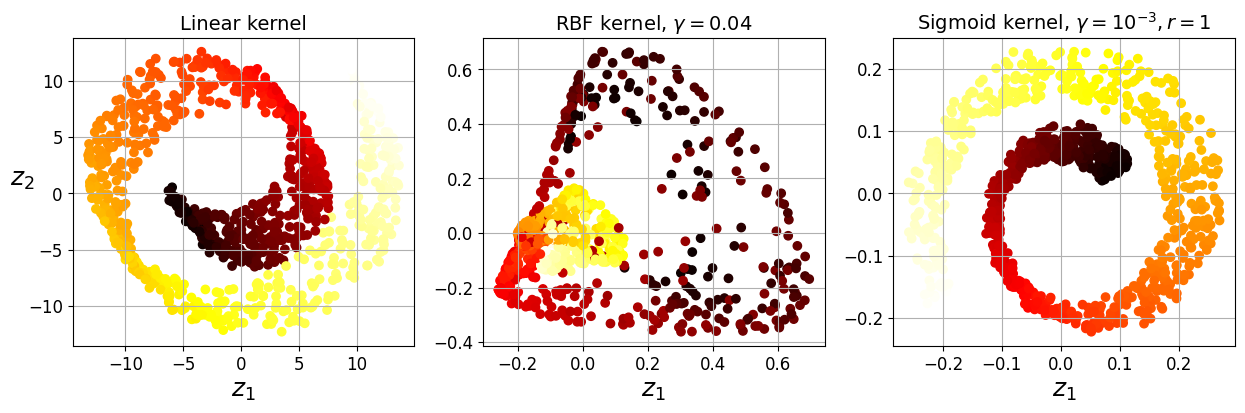

In [39]:
y = t > 6.9

plt.figure(figsize=(15, 4))
for subplot, pca, title in (
    (131, lin_pca, "Linear kernel"),
    (132, rbf_pca, "RBF kernel, $\gamma=0.04$"),
    (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"),
):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    # plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    # plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("kernel_pca_plot")
plt.show()

- Can use Grid Search, Randomized Search + PCA (tuning kernel) + an algorithm to find the optimal kernel (method)